In [45]:
import sys
import os

current_dir = os.getcwd()  # dir corrente
root_path = os.path.abspath(os.path.join(current_dir, '..')) # path per dir principale
sys.path.append(root_path)

from imports import *


In [46]:
path_dataframes="/Users/alexdediu/git-projects/Data-Challenge-PHM-Asia-Pacific-2023/dataframes"


In [47]:
with open('dfs_test_list.pkl', 'rb') as file:
    dfs_test = pickle.load(file)

with open('dfs_train_list.pkl', 'rb') as file:
    dfs_train = pickle.load(file)

In [48]:
def split_df(dfs):
    new_dfs= []

    for df in dfs:
    
        numero_di_parti = len(df) // 400
        # ottini 3 df, 0-400, 400-800, 800-1200
        for i in range(numero_di_parti):
            parte = df.iloc[i*400 : (i+1)*400]
            new_dfs.append(parte)
            
    return new_dfs

    

In [49]:
dfs_train_split = split_df(dfs_train)
dfs_test_split = split_df(dfs_test)
# for df in dfs_train:
 
#     numero_di_parti = len(df) // 400
#     # ottini 3 df, 0-400, 400-800, 800-1200
#     for i in range(numero_di_parti):
#         parte = df.iloc[i*400 : (i+1)*400]
#         dfs_train_split.append(parte)



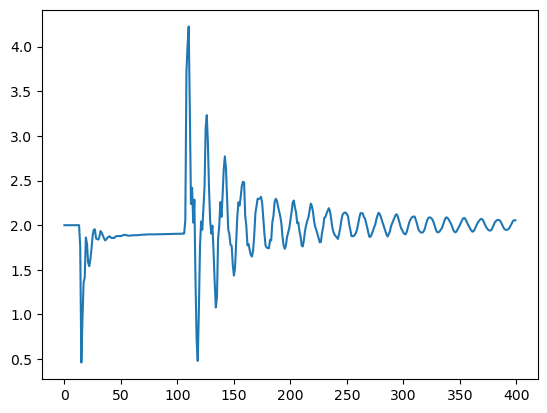

In [50]:
plt.plot(range(len(dfs_train_split[0])),dfs_train_split[0]["P1"])

In [51]:
len(dfs_test)

46

# Analisi spettrale.
calcolo FFT per ogni serie temporale (P1-P7) di ogni caso (1-177)

eliminazione della frequenza 0 (componente DC).

fftfreq calcola le frequenze associate ai coefficienti ottenuti dalla fft.

il plot seguente ha sull'asse x le frequenze e sull'asse y la fft.

per la ftt basta la parte reale o bisogna mantenere anche la fase (parte immaginaria)?


In [52]:
sampling_rate = 1000  # 1 kHz
signal_length_ms = 1200

In [53]:
def calculate_spectral_features(freqs,spectrum):

    signal_power = np.sum(spectrum)
    noise_power = np.sum(spectrum[freqs > 0.5 * sampling_rate])
    distortion_power = signal_power - noise_power 

    epsilon = 1e-10
    snr = 10 * np.log10(signal_power / (noise_power + epsilon))

    sinad = 10 * np.log10(signal_power / (noise_power + distortion_power + epsilon))

    # peak_amplitude = np.max(time_series)

    band_power = np.sum(spectrum[(freqs >= 0) & (freqs <= max(range(len(freqs))))])

    peak_value = np.max(spectrum)

    peak_freq = freqs[np.argmax(spectrum)]

    mean_power_spectrum = np.mean(spectrum)
   

    sum_power_spectrum = np.sum(spectrum)
    std_spectrum = np.std(spectrum)

    return sinad, snr, band_power, peak_value, peak_freq, sum_power_spectrum,std_spectrum

def calculate_additional_spectral_features(freqs,spectrum):
    

    harmonic_amplitude_ratio = np.max(spectrum) / np.mean(spectrum)
    main_harmonic_bandwidth = freqs[np.argmax(spectrum)] - freqs[np.argmin(spectrum)]


    return harmonic_amplitude_ratio, main_harmonic_bandwidth

In [54]:
def spectral_features(dfs_data):
    # dfs_freq = []
    dfs_fft = []
    freq_dom = []

    for df in dfs_data:
        fft_df = pd.DataFrame()
        freq_dom_col = pd.DataFrame()

        for col in df.columns:
            if col != "TIME" and col != "Case":
                fft_result = np.fft.fft(df[col]).real
                freq = np.fft.fftfreq(len(df[col]))

                positive_freq_indices = np.where(freq > 0)[0]
                fft_result = fft_result[positive_freq_indices]
                freq = freq[positive_freq_indices]

                power_spectrum = np.abs(fft_result) ** 2

                sinad, snr, band_power, peak_value, peak_freq, sum_power_spectrum, std_spectrum = calculate_spectral_features(freq, power_spectrum)
                harmonic_amplitude_ratio, main_harmonic_bandwidth = calculate_additional_spectral_features(freq, power_spectrum)

                max_val = np.max(np.abs(fft_result))

                impulse_factor = max_val / np.mean(np.abs(df[col]))
                crest_factor = max_val / np.sqrt(np.mean(np.square(df[col])))

                ampl = np.abs(fft_result)
                amplitudes_sum = np.sum(ampl)
                prob_amplitudes = ampl / amplitudes_sum
                entropy = -np.sum(prob_amplitudes * np.log2(prob_amplitudes + 1e-12))  # 1e-12 per evitare log(0)

                squared = np.square(df[col])
                mean_squared = np.mean(squared)
                rms = np.sqrt(mean_squared)

                freq_dom_col[col + "_SINAD"] = [sinad]
                freq_dom_col[col + "_rms"] = [rms]
                freq_dom_col[col + "_entropy"] = [entropy]
                freq_dom_col[col + "_SNR"] = [snr]
                freq_dom_col[col + "_crest_factor"] = [crest_factor]
                freq_dom_col[col + "_impulse_factor"] = [impulse_factor]
                freq_dom_col[col + "_BandPower"] = [band_power]
                freq_dom_col[col + "_PeakValue"] = [peak_value]
                freq_dom_col[col + "_PeakFreq"] = [peak_freq]
                freq_dom_col[col + "_SumPowerSpectrum"] = [sum_power_spectrum]
                freq_dom_col[col + "_StdPowerSpectrum"] = [std_spectrum]
                freq_dom_col[col + "_HarmonicAmplitudeRatio"] = [harmonic_amplitude_ratio]
                freq_dom_col[col + "_MainHarmonicBandwidth"] = [main_harmonic_bandwidth]

                fft_df[col + '_fft'] = fft_result

        dfs_fft.append(fft_df)
        freq_dom.append(freq_dom_col)

    return freq_dom, dfs_fft


In [55]:
dfs_sf_test,dfs_fft_test = spectral_features(dfs_test)
dfs_sf_train,dfs_fft_train= spectral_features(dfs_train)

dfs_sf_test_split,dfs_fft_test_split = spectral_features(dfs_test_split)
dfs_sf_train_split,dfs_fft_train_split= spectral_features(dfs_train_split)


In [56]:
len(dfs_train_split)

531

In [57]:
len(dfs_fft_test_split)

138

In [58]:
def calculate_column_statistics(column):
 
    statistics = {
        'mean': column.mean(),
        'median': column.median(),
        'std': column.std(),
        'min': column.min(),
        'max': column.max(),
        '25th_percentile': column.quantile(0.25),
        '75th_percentile': column.quantile(0.75),
        'kurtosis': kurtosis(column),
        'skewness': skew(column)
    
        # Puoi aggiungere altre statistiche a seconda delle tue esigenze
    }
    return pd.Series(statistics)

In [59]:
def statistics_df(dfs_list):
    dfs = []


    for df in dfs_list:
        statistics_dict = OrderedDict()    
        for col in df.columns:
            
            if (col != "TIME") and (col != "Case"):
                column_stats = calculate_column_statistics(df[col])
          
                line_integral = np.trapz(df[col])
                clearance_factor = np.max(df[col]) - np.min(df[col])

                statistics_dict[col + "_mean"] = column_stats["mean"]
                statistics_dict[col + "_median"] = column_stats["median"]
                statistics_dict[col + "_std"] = column_stats["std"]
                statistics_dict[col + "_min"] = column_stats["min"]
                statistics_dict[col + "_max"] = column_stats["max"]
                statistics_dict[col + "_25th_percentile"] = column_stats["25th_percentile"]
                statistics_dict[col + "_75th_percentile"] = column_stats["75th_percentile"]
                statistics_dict[col + "_kurtosis"] = column_stats["kurtosis"]
                statistics_dict[col + "_skewness"] = column_stats["skewness"]
                statistics_dict[col + "_variance"] = np.var(df[col])
                statistics_dict[col + "_line_integral"] = line_integral
                statistics_dict[col + "_clearance_factor"] = clearance_factor
                # statistics_dict["Case_stats_temp"] = df["Case"].iloc[0]

        statistics_df = pd.DataFrame(statistics_dict,index=[0])
        dfs.append(statistics_df)

    
    return dfs


In [60]:
dfs_stats_temp_train = statistics_df(dfs_train)
dfs_stats_fft_train = statistics_df(dfs_fft_train)
#test
dfs_stats_temp_test = statistics_df(dfs_test)
dfs_stats_fft_test = statistics_df(dfs_fft_test)


dfs_stats_temp_train_split = statistics_df(dfs_train_split)
dfs_stats_fft_train_split = statistics_df(dfs_fft_train_split)

dfs_stats_temp_test_split = statistics_df(dfs_test_split)
dfs_stats_fft_test_split = statistics_df(dfs_fft_test_split)

In [61]:
dfs_stats_fft_train

[   P1_fft_mean  P1_fft_median  P1_fft_std  P1_fft_min  P1_fft_max  \
 0     0.015146       0.135039    7.518738  -78.106946   71.621197   
 
    P1_fft_25th_percentile  P1_fft_75th_percentile  P1_fft_kurtosis  \
 0                -1.11402                1.174801         47.41948   
 
    P1_fft_skewness  P1_fft_variance  ...  P7_fft_std  P7_fft_min  P7_fft_max  \
 0        -1.825348        56.437197  ...   14.222709 -147.559506  154.581021   
 
    P7_fft_25th_percentile  P7_fft_75th_percentile  P7_fft_kurtosis  \
 0               -1.922643                2.052882        59.131407   
 
    P7_fft_skewness  P7_fft_variance  P7_fft_line_integral  \
 0        -1.012595       201.948322             18.197673   
 
    P7_fft_clearance_factor  
 0               302.140527  
 
 [1 rows x 84 columns],
    P1_fft_mean  P1_fft_median  P1_fft_std  P1_fft_min  P1_fft_max  \
 0     0.015082       0.119478    7.514693  -77.900253   71.237182   
 
    P1_fft_25th_percentile  P1_fft_75th_percentile  

In [62]:
df_stats_temp_train = pd.concat(dfs_stats_temp_train,axis=0)
df_stats_fft_train = pd.concat(dfs_stats_fft_train,axis=0)
df_sf_train = pd.concat(dfs_sf_train,axis=0)

#test
df_stats_temp_test = pd.concat(dfs_stats_temp_test,axis=0)
df_stats_fft_test = pd.concat(dfs_stats_fft_test,axis=0)
df_sf_test = pd.concat(dfs_sf_test,axis=0)

#split
df_stats_fft_train_split = pd.concat(dfs_stats_fft_train_split, axis=0)
df_stats_temp_train_split = pd.concat(dfs_stats_temp_train_split, axis=0)
df_sf_train_split = pd.concat(dfs_sf_train_split, axis=0)

df_stats_fft_test_split = pd.concat(dfs_stats_fft_test_split, axis=0)
df_stats_temp_test_split = pd.concat(dfs_stats_temp_test_split, axis=0)
df_sf_test_split = pd.concat(dfs_sf_test_split, axis=0)



In [63]:
df_sf_train_split

,P1_SINAD,P1_rms,P1_entropy,P1_SNR,P1_crest_factor,P1_impulse_factor,P1_BandPower,P1_PeakValue,P1_PeakFreq,P1_SumPowerSpectrum,...,P7_SNR,P7_crest_factor,P7_impulse_factor,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_StdPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth
0,-1.248804e-13,2.008106,6.690162,135.408712,11.910425,12.053133,3474.330846,572.041724,0.060,3474.330846,...,140.956269,23.967131,24.987604,12463.124677,2416.778796,0.060,12463.124677,266.077722,38.588957,-0.2875
0,-1.243982e-13,2.008885,6.704472,135.430344,11.786804,11.928493,3491.679825,560.663722,0.060,3491.679825,...,140.833548,22.024216,22.926072,12115.876187,2047.498444,0.060,12115.876187,248.527621,33.629610,-0.1425
0,-1.243982e-13,2.008954,6.704419,135.431035,11.789642,11.931376,3492.235037,560.972259,0.060,3492.235037,...,140.833632,22.016188,22.917754,12116.110939,2046.270386,0.060,12116.110939,248.417896,33.608788,-0.1425
0,-1.253626e-13,2.008186,6.690576,135.402722,11.911742,12.054557,3469.542148,572.213792,0.060,3469.542148,...,141.003742,24.252338,25.287783,12600.105802,2477.027968,0.060,12600.105802,269.010831,39.120986,-0.1025
0,-1.243982e-13,2.008960,6.704699,135.424299,11.787795,11.929582,3486.823207,560.799439,0.060,3486.823207,...,141.038890,23.067393,24.041178,12702.495058,2250.229459,0.060,12702.495058,262.332666,35.252575,-0.0650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-1.721325e-13,2.004028,6.694582,134.018802,7.899070,7.973013,2522.784552,250.587512,0.055,2522.784552,...,140.379425,18.134052,18.924777,10912.958303,1398.971839,0.055,10912.958303,171.208092,25.510534,-0.3700
0,-1.721325e-13,2.004092,6.694590,134.019227,7.897426,7.971359,2523.031560,250.499153,0.055,2523.031560,...,140.379481,18.135987,18.926695,10913.098014,1399.494629,0.055,10913.098014,171.228814,25.519741,-0.3700
0,-1.547746e-13,2.005668,6.575629,134.483450,13.019546,13.157105,2807.662980,681.882612,0.060,2807.662980,...,140.877303,24.607356,25.723806,12238.558687,2553.057293,0.060,12238.558687,213.758015,41.512928,-0.3450
0,-1.552567e-13,2.006496,6.572947,134.475193,13.003975,13.141151,2802.330392,680.814844,0.060,2802.330392,...,140.786393,23.756656,24.812874,11985.033847,2385.582409,0.060,11985.033847,202.241337,39.610309,-0.2450


In [64]:
df_stats_fft_test_split

,P1_fft_mean,P1_fft_median,P1_fft_std,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P1_fft_kurtosis,P1_fft_skewness,P1_fft_variance,...,P7_fft_std,P7_fft_min,P7_fft_max,P7_fft_25th_percentile,P7_fft_75th_percentile,P7_fft_kurtosis,P7_fft_skewness,P7_fft_variance,P7_fft_line_integral,P7_fft_clearance_factor
0,0.012539,-0.037066,4.560378,-25.951671,30.287358,-1.105129,1.142177,14.815115,0.396001,20.692536,...,8.554553,-53.863058,51.216825,-1.366760,1.347526,14.965922,-0.283780,72.812638,21.782340,105.079883
0,0.031160,-0.059803,4.574551,-25.923956,30.373445,-1.124636,1.221246,14.676215,0.383066,20.821356,...,8.370424,-49.317319,55.308734,-1.696681,1.486367,16.133443,0.562678,69.711916,36.846563,104.626054
0,0.031347,-0.057404,4.574816,-25.924677,30.372336,-1.125702,1.219764,14.672270,0.382683,20.823768,...,8.368104,-49.195038,55.430732,-1.687052,1.484873,16.170098,0.586203,69.673277,36.628002,104.625770
0,0.014244,0.031030,4.170327,-23.719376,19.292947,-1.043322,1.145492,11.831808,-1.357024,17.304232,...,8.010516,-49.205497,40.854907,-1.589227,1.480444,16.363284,-1.519335,63.845914,20.940510,90.060404
0,0.059836,0.025468,4.182157,-23.544770,19.535815,-1.029854,1.202994,11.475395,-1.284273,17.402545,...,7.864290,-45.026000,43.800697,-1.699242,1.642954,15.222749,-0.958841,61.536264,38.891406,88.826697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-0.029842,0.059982,4.533744,-31.673006,13.623451,-0.512606,0.678608,14.573153,-2.275102,20.451542,...,8.197961,-57.283485,28.062534,-0.965308,0.875759,16.930388,-2.182705,66.868840,-1.192561,85.346019
0,-0.029690,0.060306,4.534128,-31.676085,13.625640,-0.512679,0.678544,14.573324,-2.275059,20.455006,...,8.198344,-57.287739,28.065979,-0.967995,0.879532,16.931550,-2.182733,66.875099,-1.137452,85.353718
0,0.015667,0.090670,4.008633,-23.776911,14.130603,-1.090138,1.147148,10.294498,-1.490140,15.988390,...,7.642720,-47.820339,29.308608,-1.651151,1.482256,13.300729,-1.581467,58.117650,20.854362,77.128947
0,0.067804,0.140724,4.016502,-23.494682,14.445147,-1.071609,1.219015,9.865021,-1.392928,16.051222,...,7.467238,-43.333859,32.517947,-1.666242,2.018301,11.477823,-1.108159,55.479447,55.089438,75.851806


In [65]:
df_stats_temp_train

,P1_mean,P1_median,P1_std,P1_min,P1_max,P1_25th_percentile,P1_75th_percentile,P1_kurtosis,P1_skewness,P1_variance,...,P7_std,P7_min,P7_max,P7_25th_percentile,P7_75th_percentile,P7_kurtosis,P7_skewness,P7_variance,P7_line_integral,P7_clearance_factor
0,1.984867,1.956786,0.308519,0.436248,4.228663,1.893564,2.059497,18.304141,1.636982,0.095105,...,0.573871,-0.003006,5.017115,1.804532,2.139209,7.009600,1.005444,0.329054,2366.012724,5.020121
0,1.984931,1.957459,0.308624,0.436435,4.256737,1.893815,2.058403,18.408793,1.667283,0.095169,...,0.579382,-0.003786,4.999330,1.803312,2.141343,6.530707,0.957497,0.335404,2366.376508,5.003116
0,1.984999,1.960032,0.308539,0.436793,4.295627,1.892870,2.058726,18.574106,1.680704,0.095117,...,0.594715,-0.007141,5.000936,1.798699,2.139498,6.121365,0.999735,0.353392,2368.725329,5.008078
0,1.984965,1.958703,0.308392,0.437050,4.295622,1.893398,2.058818,18.513062,1.659309,0.095026,...,0.567000,-0.002395,5.008294,1.803063,2.137299,7.217882,1.050071,0.321221,2365.701657,5.010689
0,1.984987,1.958311,0.308432,0.437011,4.281213,1.893440,2.059063,18.366902,1.645950,0.095051,...,0.569452,-0.002607,4.998044,1.801804,2.138255,7.084213,1.047163,0.324006,2366.740718,5.000651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.984983,1.956329,0.278327,0.543228,4.016765,1.890819,2.065815,15.468806,1.866904,0.077401,...,0.554805,0.000442,4.918386,1.815840,2.134921,7.835247,0.720218,0.307552,2361.961235,4.917944
0,1.984349,1.965884,0.278177,0.820108,4.063794,1.897594,2.053114,18.672669,2.190264,0.077318,...,0.623007,-0.015324,5.228732,1.743142,2.209793,6.121074,0.679150,0.387815,2363.165121,5.244057
0,1.984209,1.971360,0.274191,0.522027,4.182883,1.894357,2.062763,21.232798,1.749215,0.075118,...,0.589093,0.001778,5.513235,1.806417,2.111299,10.941186,1.571102,0.346742,2364.069197,5.511457
0,1.985246,1.976075,0.271765,0.579673,4.103252,1.895262,2.058983,20.989922,1.990960,0.073795,...,0.589475,0.266158,4.747359,1.806350,2.139188,5.863030,1.154917,0.347191,2371.499487,4.481201


In [66]:
df_sf_train_split

,P1_SINAD,P1_rms,P1_entropy,P1_SNR,P1_crest_factor,P1_impulse_factor,P1_BandPower,P1_PeakValue,P1_PeakFreq,P1_SumPowerSpectrum,...,P7_SNR,P7_crest_factor,P7_impulse_factor,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_StdPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth
0,-1.248804e-13,2.008106,6.690162,135.408712,11.910425,12.053133,3474.330846,572.041724,0.060,3474.330846,...,140.956269,23.967131,24.987604,12463.124677,2416.778796,0.060,12463.124677,266.077722,38.588957,-0.2875
0,-1.243982e-13,2.008885,6.704472,135.430344,11.786804,11.928493,3491.679825,560.663722,0.060,3491.679825,...,140.833548,22.024216,22.926072,12115.876187,2047.498444,0.060,12115.876187,248.527621,33.629610,-0.1425
0,-1.243982e-13,2.008954,6.704419,135.431035,11.789642,11.931376,3492.235037,560.972259,0.060,3492.235037,...,140.833632,22.016188,22.917754,12116.110939,2046.270386,0.060,12116.110939,248.417896,33.608788,-0.1425
0,-1.253626e-13,2.008186,6.690576,135.402722,11.911742,12.054557,3469.542148,572.213792,0.060,3469.542148,...,141.003742,24.252338,25.287783,12600.105802,2477.027968,0.060,12600.105802,269.010831,39.120986,-0.1025
0,-1.243982e-13,2.008960,6.704699,135.424299,11.787795,11.929582,3486.823207,560.799439,0.060,3486.823207,...,141.038890,23.067393,24.041178,12702.495058,2250.229459,0.060,12702.495058,262.332666,35.252575,-0.0650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-1.721325e-13,2.004028,6.694582,134.018802,7.899070,7.973013,2522.784552,250.587512,0.055,2522.784552,...,140.379425,18.134052,18.924777,10912.958303,1398.971839,0.055,10912.958303,171.208092,25.510534,-0.3700
0,-1.721325e-13,2.004092,6.694590,134.019227,7.897426,7.971359,2523.031560,250.499153,0.055,2523.031560,...,140.379481,18.135987,18.926695,10913.098014,1399.494629,0.055,10913.098014,171.228814,25.519741,-0.3700
0,-1.547746e-13,2.005668,6.575629,134.483450,13.019546,13.157105,2807.662980,681.882612,0.060,2807.662980,...,140.877303,24.607356,25.723806,12238.558687,2553.057293,0.060,12238.558687,213.758015,41.512928,-0.3450
0,-1.552567e-13,2.006496,6.572947,134.475193,13.003975,13.141151,2802.330392,680.814844,0.060,2802.330392,...,140.786393,23.756656,24.812874,11985.033847,2385.582409,0.060,11985.033847,202.241337,39.610309,-0.2450


In [67]:
df_stats_fft_train

,P1_fft_mean,P1_fft_median,P1_fft_std,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P1_fft_kurtosis,P1_fft_skewness,P1_fft_variance,...,P7_fft_std,P7_fft_min,P7_fft_max,P7_fft_25th_percentile,P7_fft_75th_percentile,P7_fft_kurtosis,P7_fft_skewness,P7_fft_variance,P7_fft_line_integral,P7_fft_clearance_factor
0,0.015146,0.135039,7.518738,-78.106946,71.621197,-1.114020,1.174801,47.419480,-1.825348,56.437197,...,14.222709,-147.559506,154.581021,-1.922643,2.052882,59.131407,-1.012595,201.948322,18.197673,302.140527
0,0.015082,0.119478,7.514693,-77.900253,71.237182,-1.140525,1.138723,47.059477,-1.837424,56.376497,...,14.383083,-146.768987,157.578101,-1.780236,2.056278,59.247478,-0.992289,206.528301,17.809644,304.347087
0,0.015013,0.118833,7.505483,-77.645974,70.771997,-1.115429,1.150929,46.759342,-1.856198,56.238385,...,14.914381,-152.052807,146.310563,-1.888187,2.184789,56.634981,-2.283464,222.068019,15.937781,298.363370
0,0.015047,0.112339,7.495473,-77.536430,70.411246,-1.092441,1.159992,46.634645,-1.872654,56.088475,...,13.934584,-144.728434,151.166754,-1.890640,2.065447,58.403610,-0.897936,193.849023,18.374887,295.895188
0,0.015025,0.116283,7.491633,-77.426501,70.181402,-1.093679,1.159256,46.466293,-1.880469,56.031023,...,14.027710,-145.295680,151.122085,-1.846520,1.991660,58.011668,-1.017652,196.448685,17.927349,296.417764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.015030,-0.047965,7.297398,-92.806901,77.436487,-1.118049,0.970260,70.007266,-1.443299,53.163262,...,14.380495,-178.503858,125.861823,-2.526580,2.454462,55.841729,-1.982456,206.453967,19.488366,304.365681
0,0.015664,0.005288,7.368482,-76.147377,84.430242,-0.856939,0.803637,52.772163,0.628934,54.204037,...,16.465098,-148.915577,160.184505,-3.394788,3.674052,36.860117,-0.561353,270.647619,19.534516,309.100082
0,0.015804,0.031784,6.452928,-62.255302,44.345704,-0.991596,0.941290,27.231189,-0.800671,41.570882,...,13.929844,-131.186906,83.668128,-2.592496,2.886031,23.523609,-1.136497,193.717162,18.232850,214.855034
0,0.014767,0.003852,6.351174,-42.069359,46.662874,-0.920927,1.011699,18.270337,0.068160,40.270184,...,13.095214,-102.224735,109.796958,-1.577465,1.787295,28.189628,-0.423597,171.198835,14.187515,212.021693


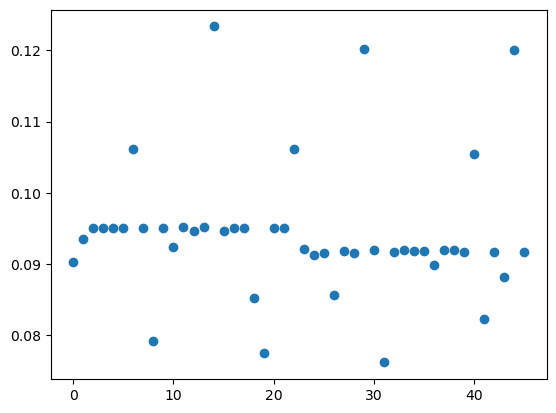

In [68]:
df_stats_temp_test["P1_variance"]
plt.scatter(list(range(len(df_stats_temp_test))),df_stats_temp_test["P1_variance"])

In [69]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def scaling_df(df, scaler):
    df_stats_scaled = scaler.transform(df)
    df = pd.DataFrame(df_stats_scaled, columns=df.columns)
    return df

scaler_temp = MinMaxScaler((0,1))
scaler_fft = MinMaxScaler((0,1))
scaler_sf = MinMaxScaler((0,1))

scaler_temp.fit(df_stats_temp_train)
scaler_fft.fit(df_stats_fft_train)
scaler_sf.fit(df_sf_train)



df_stats_temp_train = scaling_df(df_stats_temp_train, scaler_temp)
df_stats_fft_train = scaling_df(df_stats_fft_train, scaler_fft)
df_sf_train = scaling_df(df_sf_train, scaler_sf)



df_stats_temp_test = scaling_df(df_stats_temp_test, scaler_temp)
df_stats_fft_test = scaling_df(df_stats_fft_test, scaler_fft)
df_sf_test = scaling_df(df_sf_test, scaler_sf)



scaler_temp_split = MinMaxScaler((0,1))
scaler_fft_split = MinMaxScaler((0,1))
scaler_sf_split = MinMaxScaler((0,1))

scaler_temp_split.fit(df_stats_temp_train_split)
scaler_fft_split.fit(df_stats_fft_train_split)
scaler_sf_split.fit(df_sf_train_split)



df_stats_temp_train_split = scaling_df(df_stats_temp_train_split, scaler_temp_split)
df_stats_fft_train_split = scaling_df(df_stats_fft_train_split, scaler_fft_split)
df_sf_train_split = scaling_df(df_sf_train_split, scaler_sf_split)

df_stats_temp_test_split = scaling_df(df_stats_temp_test_split, scaler_temp_split)
df_stats_fft_test_split = scaling_df(df_stats_fft_test_split, scaler_fft_split)
df_sf_test_split = scaling_df(df_sf_test_split, scaler_sf_split)



In [70]:
df_sf_test_split

,P1_SINAD,P1_rms,P1_entropy,P1_SNR,P1_crest_factor,P1_impulse_factor,P1_BandPower,P1_PeakValue,P1_PeakFreq,P1_SumPowerSpectrum,...,P7_SNR,P7_crest_factor,P7_impulse_factor,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_StdPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth
0,0.991803,0.622764,0.480321,0.989526,0.891260,0.891841,0.985152,0.858690,0.6,0.985152,...,0.766073,0.764376,0.756776,0.699341,0.705380,0.012270,0.699341,0.689624,0.558238,0.592437
1,1.000000,0.709673,0.499749,0.997822,0.896016,0.896736,0.996902,0.865415,0.6,0.996902,...,0.704718,0.816005,0.802751,0.628367,0.767782,0.018405,0.628367,0.676991,0.665339,0.037815
2,1.000000,0.722302,0.499090,0.997976,0.895867,0.896587,0.997122,0.865328,0.6,0.997122,...,0.703929,0.820262,0.806875,0.627474,0.773123,0.018405,0.627474,0.677652,0.671144,0.415966
3,0.815574,0.800241,0.587931,0.752008,0.484993,0.486783,0.678042,0.401913,0.4,0.678042,...,0.580003,0.585887,0.584248,0.493241,0.515578,0.012270,0.493241,0.567876,0.507114,0.382353
4,0.823770,0.900437,0.604437,0.759791,0.473726,0.475603,0.687259,0.391286,0.4,0.687259,...,0.528194,0.429093,0.424815,0.440515,0.359860,0.012270,0.440515,0.482796,0.374568,0.357143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,0.983607,145.202587,-0.420163,0.974014,0.330262,0.325747,0.963375,0.969248,0.4,0.963375,...,0.645641,0.199457,0.170962,0.562874,0.855691,0.012270,0.562874,0.651867,0.803437,0.084034
134,0.983607,145.218234,-0.419982,0.974238,0.330343,0.325827,0.963688,0.969500,0.4,0.963688,...,0.645773,0.199451,0.170953,0.563017,0.855884,0.012270,0.563017,0.652022,0.803510,0.336134
135,0.729508,0.732800,0.730063,0.646962,0.488880,0.490354,0.558779,0.405432,0.4,0.558779,...,0.446911,0.536182,0.535471,0.361583,0.462440,0.012270,0.361583,0.354924,0.545005,0.231092
136,0.733607,0.844855,0.774933,0.652532,0.470913,0.472443,0.564868,0.388252,0.4,0.564868,...,0.382219,0.369089,0.365198,0.301922,0.300744,0.012270,0.301922,0.242836,0.398074,0.596639


In [71]:
df_stats_fft_train = df_stats_fft_train.reset_index(drop=True)
df_stats_temp_train = df_stats_temp_train.reset_index(drop=True)
df_sf_train= df_sf_train.reset_index(drop=True)
#test
df_stats_fft_test = df_stats_fft_test.reset_index(drop=True)
df_stats_temp_test = df_stats_temp_test.reset_index(drop=True)
df_sf_test = df_sf_test.reset_index(drop=True)


df_stats_fft_test_split = df_stats_fft_test_split.reset_index(drop=True)
df_stats_temp_test_split = df_stats_temp_test_split.reset_index(drop=True)
df_sf_test_split = df_sf_test_split.reset_index(drop=True)


df_stats_fft_train_split = df_stats_fft_train_split.reset_index(drop=True)
df_stats_temp_train_split = df_stats_temp_train_split.reset_index(drop=True)
df_sf_train_split = df_sf_train_split.reset_index(drop=True)

In [72]:

df_features_train = pd.concat([df_stats_fft_train,df_stats_temp_train,df_sf_train],axis=1)
df_features_test = pd.concat([df_stats_fft_test,df_stats_temp_test,df_sf_test],axis=1)

df_features_train_split = pd.concat([df_stats_fft_train_split, df_stats_temp_train_split, df_sf_train_split], axis=1)

df_features_test_split = pd.concat([df_stats_fft_test_split, df_stats_temp_test_split, df_sf_test_split], axis=1)


In [73]:
df_features_train_split

,P1_fft_mean,P1_fft_median,P1_fft_std,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P1_fft_kurtosis,P1_fft_skewness,P1_fft_variance,...,P7_SNR,P7_crest_factor,P7_impulse_factor,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_StdPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth
0,0.442692,0.724545,0.728887,0.302783,0.297822,0.317366,0.590160,3.824206e-01,0.129474,0.692130,...,0.552726,0.584951,0.582910,0.465241,0.513837,0.01227,0.465241,0.534149,0.524858,0.243697
1,0.942380,0.785278,0.735861,0.317851,0.311983,0.373316,0.638933,3.616752e-01,0.161884,0.699707,...,0.512717,0.437503,0.433336,0.425134,0.367830,0.01227,0.425134,0.453405,0.392997,0.487395
2,0.943969,0.793574,0.736092,0.317440,0.311860,0.371919,0.638514,3.616923e-01,0.161620,0.699958,...,0.512744,0.436894,0.432733,0.425161,0.367345,0.01227,0.425161,0.452900,0.392443,0.487395
3,0.438839,0.723314,0.726877,0.302556,0.289849,0.383880,0.625447,3.775594e-01,0.128729,0.689949,...,0.568203,0.606595,0.604689,0.481062,0.537658,0.01227,0.481062,0.547643,0.539004,0.554622
4,0.942394,0.823747,0.733827,0.317670,0.304123,0.383480,0.698345,3.567968e-01,0.161299,0.697495,...,0.579662,0.516670,0.514242,0.492888,0.447986,0.01227,0.492888,0.516919,0.436149,0.617647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,0.045665,0.314880,0.297516,0.980204,0.161322,0.507897,0.265517,0.000000e+00,0.691587,0.258641,...,0.364665,0.142278,0.143025,0.286197,0.111415,0.00000,0.286197,0.097679,0.177124,0.105042
527,0.049514,0.321749,0.297640,0.980081,0.161177,0.508719,0.261302,6.212933e-07,0.691376,0.258755,...,0.364683,0.142425,0.143164,0.286213,0.111622,0.00000,0.286213,0.097774,0.177369,0.105042
528,0.442130,0.453373,0.434133,0.164398,0.099745,0.674815,0.241775,5.017391e-01,0.036502,0.388438,...,0.526981,0.633538,0.636324,0.439304,0.567719,0.01227,0.439304,0.293440,0.602601,0.147059
529,0.313744,0.466544,0.431662,0.165687,0.100016,0.739933,0.184579,5.011974e-01,0.052996,0.386028,...,0.497343,0.568978,0.570232,0.410022,0.501503,0.01227,0.410022,0.240455,0.552014,0.315126


In [74]:
df_features_train

,P1_fft_mean,P1_fft_median,P1_fft_std,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P1_fft_kurtosis,P1_fft_skewness,P1_fft_variance,...,P7_SNR,P7_crest_factor,P7_impulse_factor,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_StdPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth
0,0.860683,0.947263,0.892643,0.289725,0.646085,0.396821,0.943984,0.461597,0.387633,0.878385,...,0.553568,0.647181,0.650140,0.472297,0.597727,0.8,0.472297,0.725271,0.558522,0.813644
1,0.852472,0.881227,0.890624,0.293799,0.640009,0.356142,0.868280,0.455896,0.385014,0.876131,...,0.587760,0.688050,0.693058,0.507478,0.644958,0.8,0.507478,0.767706,0.577813,0.900166
2,0.843624,0.878493,0.886027,0.298811,0.632649,0.394658,0.893893,0.451143,0.380942,0.871002,...,0.698368,0.602476,0.611104,0.626842,0.558590,1.0,0.626842,0.863177,0.414686,0.615641
3,0.848008,0.850933,0.881030,0.300970,0.626942,0.429939,0.912911,0.449168,0.377372,0.865435,...,0.491161,0.600616,0.601133,0.410084,0.545026,0.8,0.410084,0.643043,0.554054,0.221298
4,0.845165,0.867672,0.879113,0.303136,0.623305,0.428040,0.911366,0.446502,0.375677,0.863301,...,0.511471,0.598389,0.599534,0.430053,0.544344,0.8,0.430053,0.660353,0.537570,0.432612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0.845774,0.170685,0.782153,0.000000,0.738090,0.390637,0.514795,0.819289,0.470502,0.756802,...,0.587213,1.000000,1.000000,0.506908,1.000000,0.4,0.506908,0.715115,0.923026,0.695507
173,0.927244,0.396663,0.817638,0.328347,0.848741,0.791386,0.165169,0.546360,0.919978,0.795453,...,1.000000,0.713938,0.733629,1.000000,0.686769,0.6,1.000000,0.848233,0.320495,0.995008
174,0.945257,0.509101,0.360605,0.602150,0.214549,0.584715,0.454008,0.141901,0.609891,0.326300,...,0.490124,0.310141,0.314049,0.409072,0.260226,0.4,0.409072,0.043048,0.260117,0.136439
175,0.811979,0.390568,0.309811,1.000000,0.251210,0.693178,0.601747,0.000000,0.798344,0.277997,...,0.301713,0.000000,0.000000,0.236099,0.000000,0.0,0.236099,0.000000,0.073649,0.452579


In [75]:
def feature_selection_anova(df_X,df_y,n_features):
    X = df_X
    y = df_y['binary_condition']
    
    f_values, p_values = f_classif(X, y)

    results = pd.DataFrame({'Feature': X.columns, 'F_Value': f_values, 'P_Value': p_values})

    results = results.sort_values(by='F_Value', ascending=False)

    top_features = results.head(n_features)
    features = top_features["Feature"].values
    # features=np.concatenate([features, ["binary_condition"]])

    plt.figure(figsize=(10, 8))
    plt.barh(top_features["Feature"], top_features["F_Value"], color='skyblue')
    plt.xlabel('F-Value')
    plt.ylabel('Feature')
    plt.title('Top Features - ANOVA F-Value')
    plt.gca().invert_yaxis() 
    plt.show()
    return features

In [76]:
def feature_selection_chi2(df_X, df_y, n_features):
    X = df_X
    y = df_y['binary_condition']

    chi2_selector = SelectKBest(chi2, k=n_features)
    chi2_selector.fit(X, y)

    scores = chi2_selector.scores_
    selected_features = chi2_selector.get_support(indices=True)
    feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})
    feature_scores = feature_scores.sort_values(by='Score', ascending=False)
    
    top_features = feature_scores.head(n_features)
    features = top_features["Feature"].values
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Score', y='Feature', data=top_features, palette='viridis')
    plt.title('Top Features - Chi-Square Scores')
    plt.xlabel('Chi-Square Score')
    plt.ylabel('Feature')
    plt.show()

    return features


In [77]:
def feature_selection_random_forest(df_X, df_y, n_features):
    X = df_X
    y = df_y['binary_condition']

    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X, y)

    importances = rf_model.feature_importances_
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    
    top_features = feature_importances.head(n_features)
    features = top_features["Feature"].values

    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
    plt.title('Top Features - Random Forest Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.show()

    return features

In [78]:
df_labels_train = pd.read_csv(f"{path_dataframes}/df_labels_train.csv")
df_labels_test = pd.read_csv(f"{path_dataframes}/df_labels_test.csv")


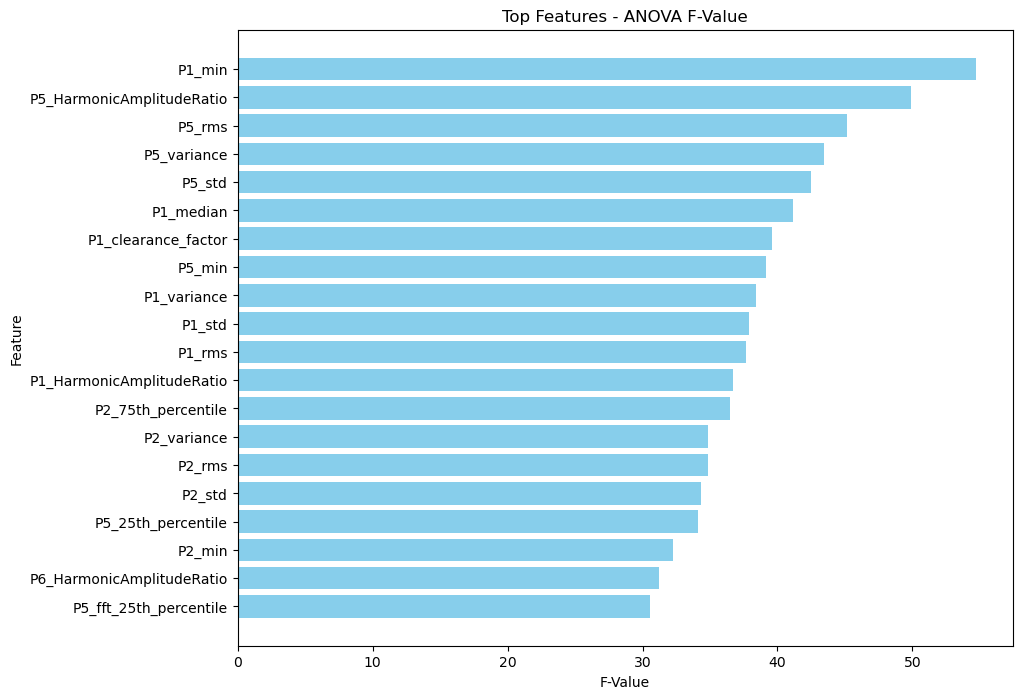

In [79]:
features_train = feature_selection_anova(df_features_train,df_labels_train,20)

# features_test= feature_selection_anova(df_features_test,df_labels_test,10)

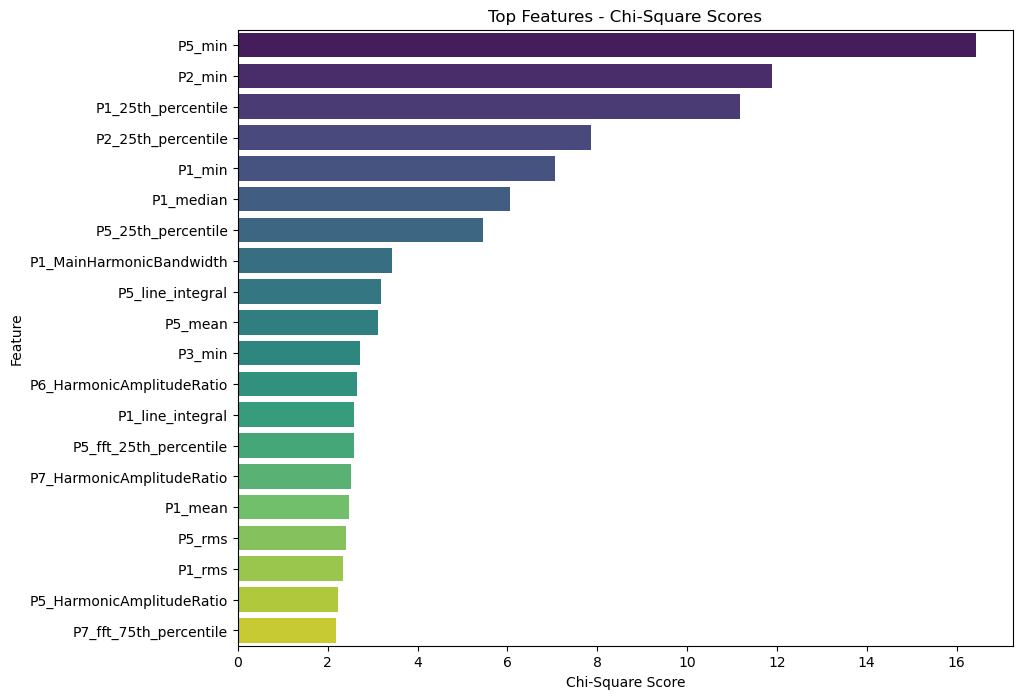

In [80]:
features_chi2_train = feature_selection_chi2(df_features_train,df_labels_train,20)


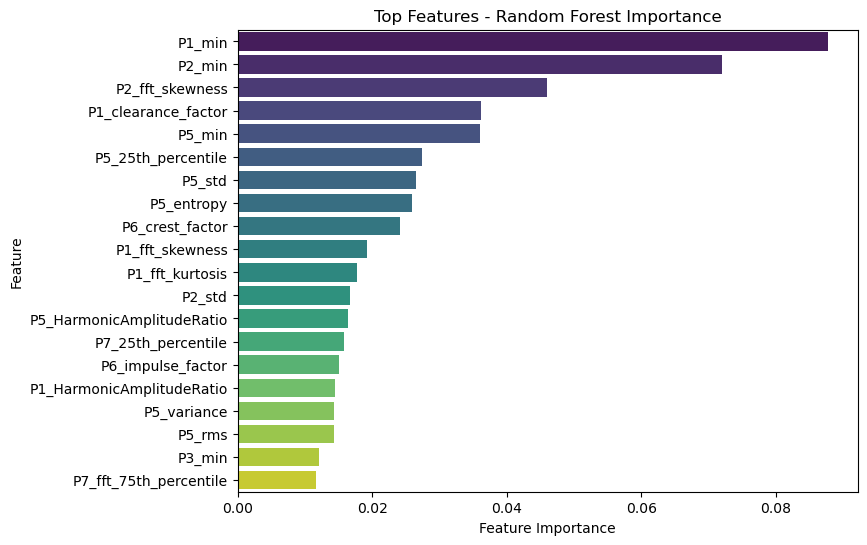

In [81]:
features_rf_train = feature_selection_random_forest(df_features_train,df_labels_train,20)


In [82]:
features_train

array(['P1_min', 'P5_HarmonicAmplitudeRatio', 'P5_rms', 'P5_variance',
       'P5_std', 'P1_median', 'P1_clearance_factor', 'P5_min',
       'P1_variance', 'P1_std', 'P1_rms', 'P1_HarmonicAmplitudeRatio',
       'P2_75th_percentile', 'P2_variance', 'P2_rms', 'P2_std',
       'P5_25th_percentile', 'P2_min', 'P6_HarmonicAmplitudeRatio',
       'P5_fft_25th_percentile'], dtype=object)

In [83]:
df_features_test_split

,P1_fft_mean,P1_fft_median,P1_fft_std,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P1_fft_kurtosis,P1_fft_skewness,P1_fft_variance,...,P7_SNR,P7_crest_factor,P7_impulse_factor,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_StdPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth
0,0.416985,0.375305,0.987565,0.174560,0.908963,0.260310,0.635246,0.579881,0.821963,0.985280,...,0.766073,0.764376,0.756776,0.699341,0.705380,0.012270,0.699341,0.689624,0.558238,0.592437
1,0.615662,0.324542,0.997434,0.176306,0.913415,0.229975,0.775072,0.572322,0.816869,0.996958,...,0.704718,0.816005,0.802751,0.628367,0.767782,0.018405,0.628367,0.676991,0.665339,0.037815
2,0.617656,0.329898,0.997619,0.176261,0.913357,0.228317,0.772452,0.572108,0.816718,0.997177,...,0.703929,0.820262,0.806875,0.627474,0.773123,0.018405,0.627474,0.677652,0.671144,0.415966
3,0.435186,0.527338,0.715952,0.315264,0.340405,0.356424,0.641108,0.417544,0.131567,0.678125,...,0.580003,0.585887,0.584248,0.493241,0.515578,0.012270,0.493241,0.567876,0.507114,0.382353
4,0.921623,0.514920,0.724190,0.326270,0.352964,0.377368,0.742795,0.398150,0.160219,0.687037,...,0.528194,0.429093,0.424815,0.440515,0.359860,0.012270,0.440515,0.482796,0.374568,0.357143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,-0.035191,0.591979,0.969018,-0.186064,0.047216,1.181725,-0.184537,0.566714,-0.230002,0.963434,...,0.645641,0.199457,0.170962,0.562874,0.855691,0.012270,0.562874,0.651867,0.803437,0.084034
134,-0.033563,0.592702,0.969286,-0.186258,0.047329,1.181611,-0.184650,0.566723,-0.229984,0.963748,...,0.645773,0.199451,0.170953,0.563017,0.855884,0.012270,0.563017,0.652022,0.803510,0.336134
135,0.450367,0.660493,0.603356,0.311638,0.073442,0.283621,0.644036,0.333891,0.079141,0.558841,...,0.446911,0.536182,0.535471,0.361583,0.462440,0.012270,0.361583,0.354924,0.545005,0.231092
136,1.006628,0.772247,0.608835,0.329427,0.089709,0.312436,0.771128,0.310521,0.117427,0.564537,...,0.382219,0.369089,0.365198,0.301922,0.300744,0.012270,0.301922,0.242836,0.398074,0.596639


In [84]:
df_features_train.to_csv(f"{path_dataframes}/df_train_complete.csv",index_label="index")
df_features_test.to_csv(f"{path_dataframes}/df_test_complete.csv",index_label="index")

#split
df_features_train_split.to_csv(f"{path_dataframes}/df_train_split.csv",index_label="index")
df_features_test_split.to_csv(f"{path_dataframes}/df_test_split.csv",index_label="index")

In [85]:
df_features_train = df_features_train[features_rf_train]
df_features_test= df_features_test[features_rf_train]

In [86]:
# df_features_train.to_csv(f"{path_dataframes}/df_train.csv",index_label="index")
# df_features_test.to_csv(f"{path_dataframes}/df_test.csv",index_label="index")

In [87]:
df_features_train

,P1_min,P2_min,P2_fft_skewness,P1_clearance_factor,P5_min,P5_25th_percentile,P5_std,P5_entropy,P6_crest_factor,P1_fft_skewness,P1_fft_kurtosis,P2_std,P5_HarmonicAmplitudeRatio,P7_25th_percentile,P6_impulse_factor,P1_HarmonicAmplitudeRatio,P5_variance,P5_rms,P3_min,P7_fft_75th_percentile
0,0.151379,0.014342,0.467707,0.835385,0.002855,0.173932,0.990348,0.501952,0.601851,0.387633,0.461597,0.764873,0.404716,0.557123,0.606964,0.500515,0.989111,0.908139,0.062465,0.283515
1,0.151707,0.014171,0.461777,0.856063,0.002856,0.177174,0.974082,0.501219,0.596881,0.385014,0.455896,0.764588,0.386983,0.548320,0.601929,0.496295,0.970816,0.957102,0.062465,0.285017
2,0.152334,0.014027,0.453730,0.884633,0.002595,0.180487,0.948400,0.545951,0.585280,0.380942,0.451143,0.774074,0.385712,0.515050,0.590337,0.492228,0.942070,0.908687,0.062465,0.341813
3,0.152786,0.014103,0.448720,0.884439,0.002830,0.181395,0.968475,0.514646,0.579044,0.377372,0.449168,0.773988,0.384052,0.546530,0.584201,0.492075,0.964525,0.937148,0.062465,0.289069
4,0.152716,0.014159,0.445623,0.873784,0.003023,0.194015,0.978674,0.512726,0.575239,0.375677,0.446502,0.767477,0.382267,0.537448,0.580482,0.490276,0.975974,0.961120,0.062465,0.256458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0.339054,0.087961,0.451714,0.598945,0.005946,0.259250,0.536422,0.313649,0.899923,0.470502,0.819289,1.000000,1.000000,0.638680,0.932304,1.000000,0.504254,0.205255,0.060095,0.460996
173,0.824787,0.040686,0.970296,0.428516,0.880071,0.221795,0.801969,0.000000,0.964706,0.919978,0.546360,0.675020,0.697196,0.114359,0.978942,0.717433,0.781425,0.719323,0.062464,1.000000
174,0.301860,0.026831,0.702085,0.737837,0.592579,0.218800,0.608061,0.487628,0.606962,0.609891,0.141901,0.606348,0.438246,0.570718,0.618512,0.362797,0.577233,0.344787,0.055959,0.651730
175,0.402989,0.024886,0.868546,0.636050,0.440788,0.219502,0.530013,0.801111,0.000000,0.798344,0.000000,0.599916,0.000000,0.570237,0.000000,0.000000,0.497790,0.204130,0.056165,0.166138


In [88]:
df_features_test

,P1_min,P2_min,P2_fft_skewness,P1_clearance_factor,P5_min,P5_25th_percentile,P5_std,P5_entropy,P6_crest_factor,P1_fft_skewness,P1_fft_kurtosis,P2_std,P5_HarmonicAmplitudeRatio,P7_25th_percentile,P6_impulse_factor,P1_HarmonicAmplitudeRatio,P5_variance,P5_rms,P3_min,P7_fft_75th_percentile
0,0.371555,0.892153,0.696309,0.878211,0.048438,0.251141,0.764978,0.510393,0.690018,0.722514,0.431102,0.826867,0.529602,0.607413,0.688686,0.534043,0.741722,0.538355,0.414883,0.187251
1,0.182168,0.007976,0.632379,0.729427,0.003761,0.174802,0.988548,0.514892,0.656619,0.402390,0.497599,0.705973,0.428010,0.556326,0.661921,0.524429,0.987083,0.980064,0.083922,0.234609
2,0.152192,0.014128,0.455493,0.860323,0.002697,0.176327,0.950542,0.542544,0.577372,0.382190,0.453568,0.771222,0.390038,0.399915,0.582809,0.493879,0.944461,0.866643,0.062465,0.371766
3,0.162786,0.014086,0.464602,0.868178,0.018448,0.169909,0.935939,0.537476,0.590313,0.385496,0.455912,0.772385,0.396816,0.445276,0.595445,0.494610,0.928183,0.930225,0.062464,0.169329
4,0.152803,0.014132,0.449128,0.866098,0.002987,0.179430,0.955406,0.544531,0.571764,0.377637,0.449457,0.771016,0.385249,0.487430,0.577447,0.491803,0.949895,0.876601,0.062465,0.209134
5,0.152057,0.014342,0.457566,0.842303,0.003052,0.176327,0.992252,0.511642,0.596276,0.381740,0.456093,0.766379,0.397708,0.556058,0.602371,0.497038,0.991257,0.945323,0.062465,0.233556
6,1.861598,1.726244,0.662373,0.921347,1.884693,15.878233,1.020122,-0.883680,0.028507,0.496075,0.284268,0.816715,0.472094,7.609692,-0.005268,0.443278,1.022777,67.564014,1.543868,-0.213066
7,0.152060,0.014342,0.459112,0.838368,0.002945,0.179970,0.990517,0.509608,0.583737,0.382632,0.456525,0.766263,0.393583,0.557067,0.590372,0.497270,0.989302,0.961413,0.062465,0.295266
8,0.307737,0.036904,0.511675,0.715520,0.592579,0.200950,0.807430,0.693182,0.879638,0.496104,0.219519,0.461677,0.621510,0.489964,0.897568,0.519669,0.787317,0.682774,0.054973,0.394476
9,0.152046,0.014222,0.459471,0.864000,0.002757,0.179866,0.979796,0.504743,0.597150,0.383591,0.456875,0.770776,0.390251,0.554101,0.602655,0.497029,0.977235,0.967401,0.062465,0.269756
